# Asset Pricing Analysis
## Omitting Item 1A from 10-Ks
## Time series, industry properties, univariate sorts, robustness tests

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from functools import reduce
from linearmodels.panel import PanelOLS
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import itertools 
from decimal import Decimal
from scipy.stats import percentileofscore

In [3]:
#import functions from functions.py
from function_definitions import *

## Analysis of the cybersecurity risk measures

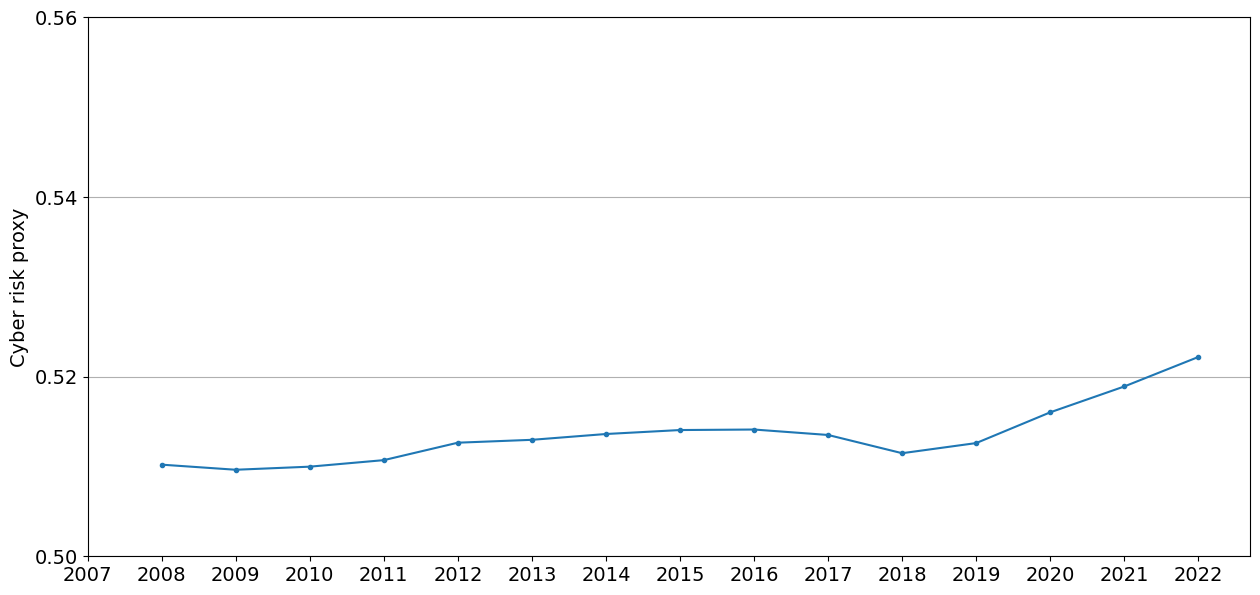

In [4]:
#plot the average of the cyber risk measure
cyber_measures_path = '../data/cyber_risk_measures/doc2vec/'
general_cybersec_no1A = pd.read_csv(cyber_measures_path+'general_cybersec_scores_no1A.csv.gz', index_col = 0)
general_cybersec_no1A.mean(1).plot(style = '.-',figsize = (15,7),  yticks = np.arange(0.50,0.58,0.02),
                                   xticks = np.arange(2007,2023)).grid(axis = 'y')
plt.ylabel('Cyber risk proxy', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

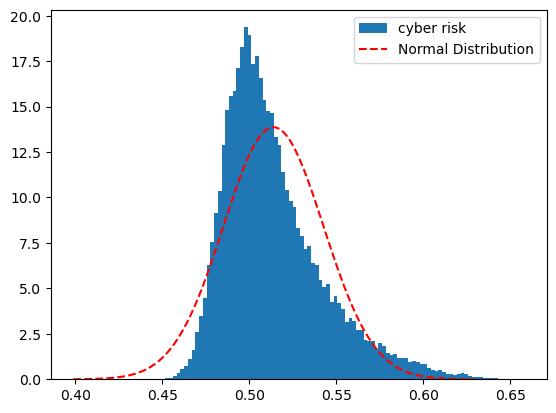

In [7]:
#plot the distribution of cyber scores
general_cybersec_no1A.stack().hist(bins = 100, density = True, label = 'cyber risk', grid = False)
# Fit a normal distribution to the data
mu, sigma = general_cybersec_no1A.stack().mean(), general_cybersec_no1A.stack().std()
# Generate points along the x-axis for the normal distribution curve
x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 100)
# Calculate the corresponding y-values using the normal distribution formula
y = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
plt.plot(x, y, color='red', label='Normal Distribution', linestyle = '--')
plt.legend()
plt.show()

In [8]:
#Compute the skewness of the cyber risk measure
print(f'Skew = {general_cybersec_no1A.diff().stack().skew()}')
#copute the kurtosis
print(f'Kurtosis = {general_cybersec_no1A.diff().stack().kurtosis()}')

Skew = 0.3712761155078098
Kurtosis = 5.983355229979425


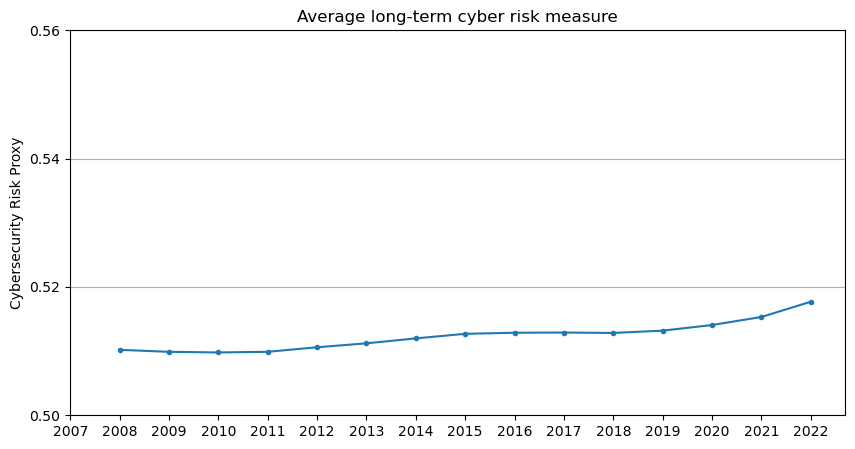

In [9]:
#plot the average of the long-term cyber risk measure
long_term_cybersec = general_cybersec_no1A.expanding().mean()
long_term_cybersec[general_cybersec_no1A.isnull()] = np.nan
ax = long_term_cybersec.mean(1).plot(style = '.-',figsize = (10,5), yticks = np.arange(0.50,0.58,0.02),
                                   xticks = np.arange(2007,2023)).grid(axis = 'y')

plt.title('Average long-term cyber risk measure')
plt.ylabel('Cybersecurity Risk Proxy')
plt.show()

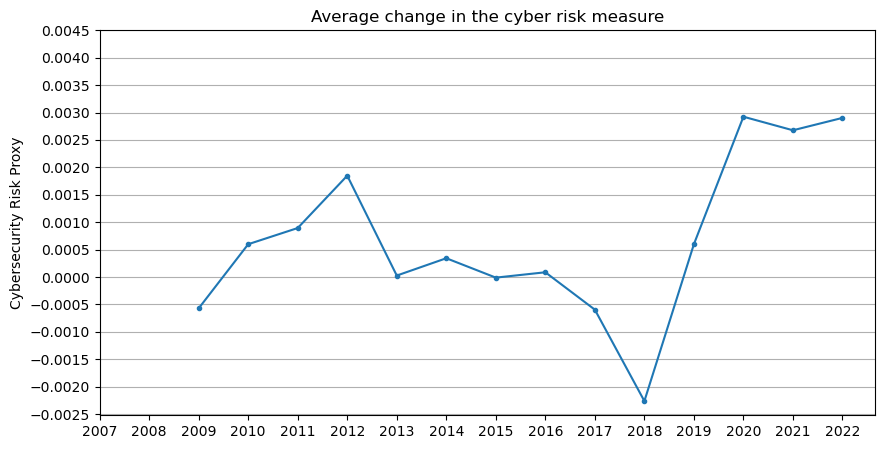

In [10]:
#plot the average of the change in the cyber risk measure
ax = general_cybersec_no1A.diff().mean(1).plot(style = '.-',figsize = (10,5), yticks = np.arange(-0.0025,0.005,0.0005),
                                   xticks = np.arange(2007,2023)).grid(axis = 'y')
plt.title('Average change in the cyber risk measure')
plt.ylabel('Cybersecurity Risk Proxy')
plt.show()

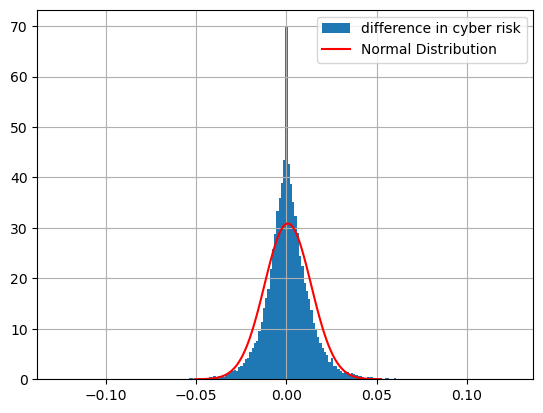

count    47044.000000
mean         0.000760
std          0.012916
min         -0.125414
1%          -0.032806
25%         -0.005675
50%          0.000033
75%          0.006836
99%          0.038163
max          0.124336
dtype: float64

In [13]:
#plot the distribution of the change in cyber scores
general_cybersec_no1A.diff().stack().hist(bins = 200, density = True, label = 'difference in cyber risk')
# Fit a normal distribution to the data
mu, sigma = general_cybersec_no1A.diff().stack().mean(), general_cybersec_no1A.diff().stack().std()
# Generate points along the x-axis for the normal distribution curve
x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 100)
# Calculate the corresponding y-values using the normal distribution formula
y = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
plt.plot(x, y, color='red', label='Normal Distribution')
plt.legend()
plt.show()
p = [0.01,0.25,0.5,0.75,0.99]
general_cybersec_no1A.diff().stack().describe(percentiles = p)

## Cybersecurity risk by industry

In [14]:
#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)
stocknames.FF_Industry_code = stocknames.FF_Industry_code.astype(float)
#read in the general cybersecurity measure
cyber_measures_path = '../data/cyber_risk_measures/doc2vec/'
general_cybersec = pd.read_csv(cyber_measures_path+'general_cybersec_scores_no1A.csv.gz', index_col = 0)

#calculate the average cybersecurity score by industry
avg_cyber_industry = []
for industry in range(1,13):
    firms = stocknames[stocknames.FF_Industry_code == industry].ticker.values
    firms = firms[np.isin(firms, general_cybersec.columns)]
    avg_cyber_industry.append(np.nanmean(general_cybersec.loc[:,firms]))## Cybersecurity risk by industry

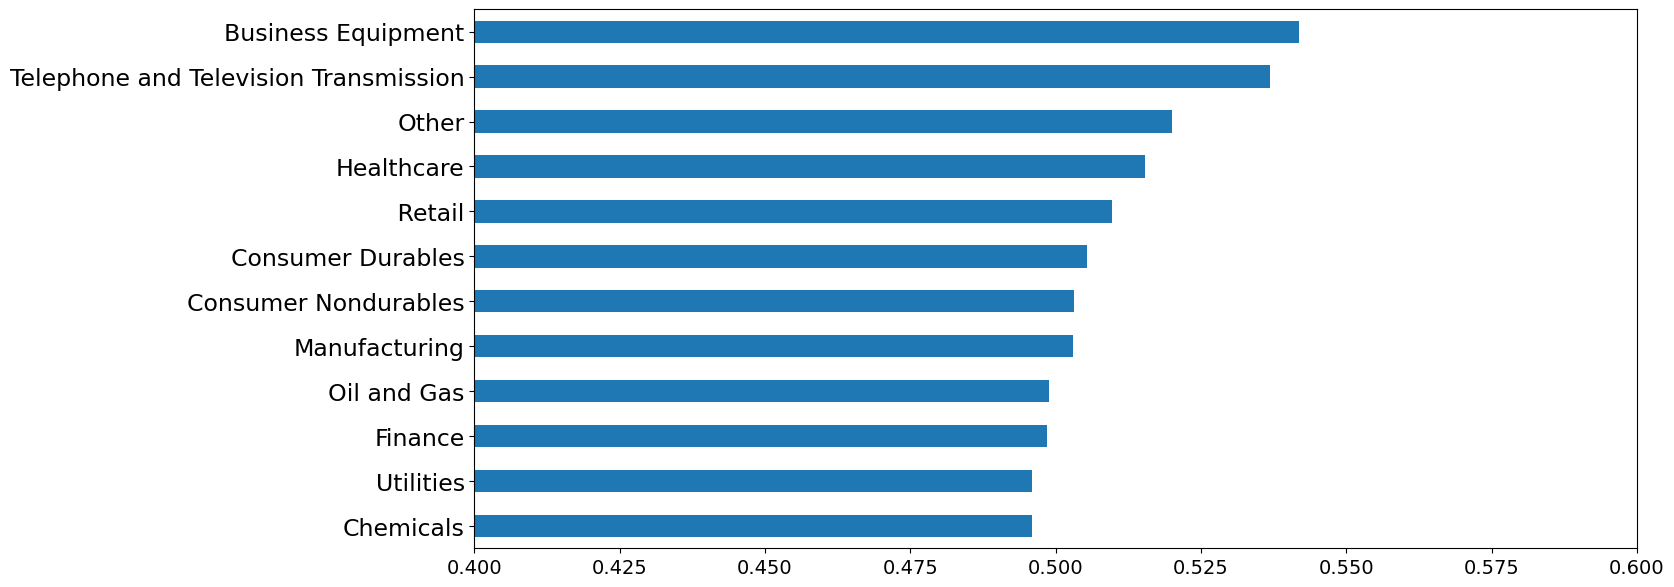

In [15]:
#plot the average cybersecurity score by industry
avg_cyber_industry = pd.DataFrame(avg_cyber_industry, index = ['Consumer Nondurables', 'Consumer Durables',
                                                                 'Manufacturing', 'Oil and Gas',
                                                                 'Chemicals', 'Business Equipment',
                                                                 'Telephone and Television Transmission',
                                                                 'Utilities', ' Retail', 'Healthcare',
                                                                 'Finance', 'Other'])
avg_cyber_industry.sort_values(0).plot.barh(legend = False, figsize = (15,7))
#plt.title('Average cybersecurity risk by industry', fontsize = 18)
plt.xlim(0.4,0.6)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 17)
plt.show()

## Univariate portfolio sorts

### General Cyber risk 

In [44]:
#read in the necessary files (firm characteristics)
read_path = '../data/returns/'

returns = pd.read_csv(read_path+'monthly_returns.csv.gz', index_col = 'date')
mkt_caps = pd.read_csv(read_path+'monthly_mkt_caps.csv.gz', index_col = 'date')
#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)
stocknames.FF_Industry_code = stocknames.FF_Industry_code.astype(float)
#read in the general cybersecurity measure
cyber_measures_path = '../data/cyber_risk_measures/doc2vec/'
general_cybersec = pd.read_csv(cyber_measures_path+'general_cybersec_scores_no1A.csv.gz', index_col = 0)
long_term_cybersec = general_cybersec.expanding().mean()
long_term_cybersec[general_cybersec.isnull()] = np.nan

returns.index = pd.to_datetime(returns.index)
mkt_caps.index = pd.to_datetime(mkt_caps.index)

#Factor returns
FF5 = pd.read_csv('../data/FF_factors/FF5.csv',skiprows = 3, index_col = 0)[:714].astype(float)
FF5 = FF5/100 # in percent?????
FF5.index.rename('date', inplace = True)
FF5.index = pd.to_datetime(FF5.index, format = '%Y%m')
momentum = pd.read_csv('../data/FF_factors/Momentum.csv',skiprows = 13, index_col = 0)[:1153].astype(float)
momentum = momentum/100 # in percent?????
momentum.index.rename('date', inplace = True)
momentum.index = pd.to_datetime(momentum.index, format = '%Y%m')
momentum.columns = ['UMD']
FF5 = FF5.merge(momentum,left_index = True,right_index = True)

In [45]:
dates = pd.date_range(start = '01-01-2009', end = '12-01-2022', freq = 'MS', inclusive = 'left')
quarters = dates[::3]
nb_firms = []
mkt_values = []
book_to_markets = []
ROAs = []
risk_index_quintiles = []

#drop firms with less than 3 years (table 7 caption)
general_cybersec = general_cybersec.loc[:,(~general_cybersec.isnull()).sum()>3]

ew_ret = {}
vw_ret = {}
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #Cyber scores for the year
        Cybersec = general_cybersec.loc[month.year,:].dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],Cybersec.index].dropna()
        Cybersec = Cybersec.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:dates[i+1]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        Cybersec = Cybersec[Cybersec.index.isin(firms_with_ret)]

        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[Cybersec.index.values]
        fd[fd_col] = pd.to_datetime(fd[fd_col])

        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        Cybersec.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        Cybersec.dropna(inplace = True)
        mkt_caps_ = mkt_caps_.loc[mkt_caps_.index.isin(Cybersec.index)]

        #sort firms into quintiles
        quintiles = pd.qcut(Cybersec, q = 5, labels = False)

        quantile_weights = []
        for q in range(5):
            firms = quintiles[quintiles == q].index
            quantile_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))
            nb_firms.append(len(firms))
    
    ew_ret[month] = []
    vw_ret[month] = []
    for q in range(5):
        firms = quintiles[quintiles == q].index
        quantile_ret = returns.loc[month, firms]
        #equally weighted portfolios
        ew_ret[month].append(quantile_ret.mean())
        #value weighted portfolios
        vw_ret[month].append(quantile_ret.multiply(quantile_weights[q]).sum())
        
        #get current risk index of the portfolio
        cyber = general_cybersec.loc[month.year,firms]
        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[firms]
        fd[fd_col] = pd.to_datetime(fd[fd_col])
        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        cyber.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        risk_index_quintiles.append(cyber.multiply(quantile_weights[q]).sum())

idx = ['quintile_'+str(i) for i in range(5)]
ew_ret = pd.DataFrame(ew_ret, index = idx).T
vw_ret = pd.DataFrame(vw_ret, index = idx).T
risk_index_quintiles = np.reshape(risk_index_quintiles,(-1,5))
nb_firms = np.reshape(nb_firms,(-1,5))

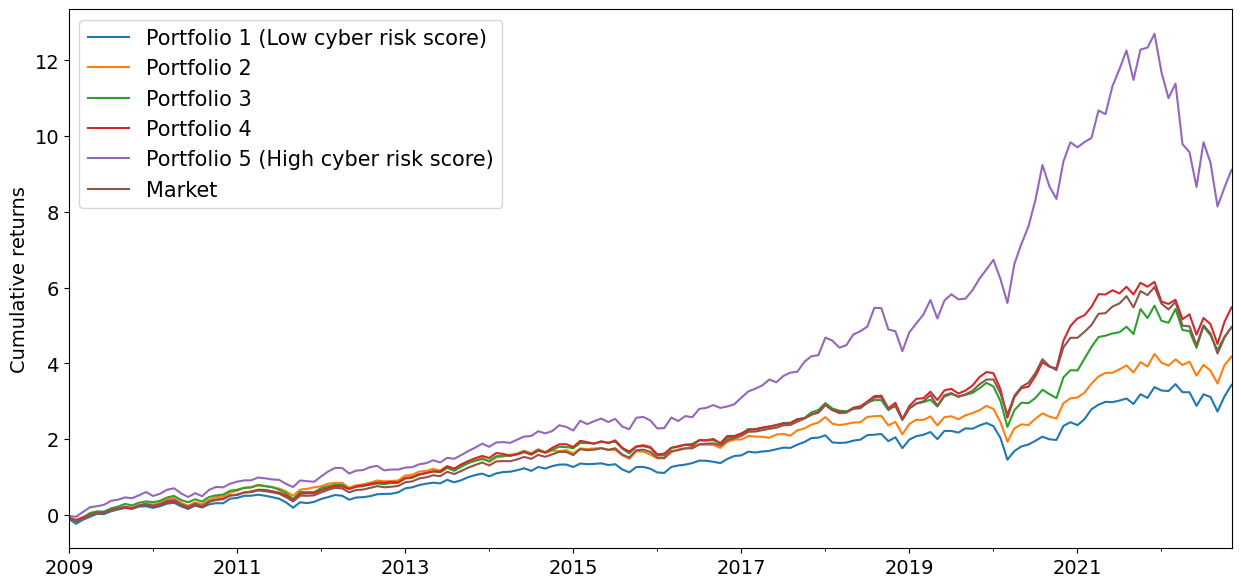

In [46]:
#plot the cumulative return of the quintile portfolios and the market portfolio
Mkt = FF5['Mkt-RF'].add(FF5['RF'])
Mkt.name = 'Mkt'
temp = pd.concat([vw_ret, Mkt[Mkt.index.isin(vw_ret.index)]], axis = 1)
#temp['LS'] = temp.quintile_4.sub(temp.quintile_0)
((temp+1).cumprod()-1).plot(figsize = (15,7)) #, style = ['-',':','--','-.','--.','-x']
#plt.title('Cumulative Returns', fontsize = 18)
plt.legend(['Portfolio 1 (Low cyber risk score)', 'Portfolio 2', 'Portfolio 3',
            'Portfolio 4', 'Portfolio 5 (High cyber risk score)',
            'Market'], fontsize = 15)#,'Long Short Portfolio (H-L)'
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Cumulative returns', fontsize = 14)
plt.show()

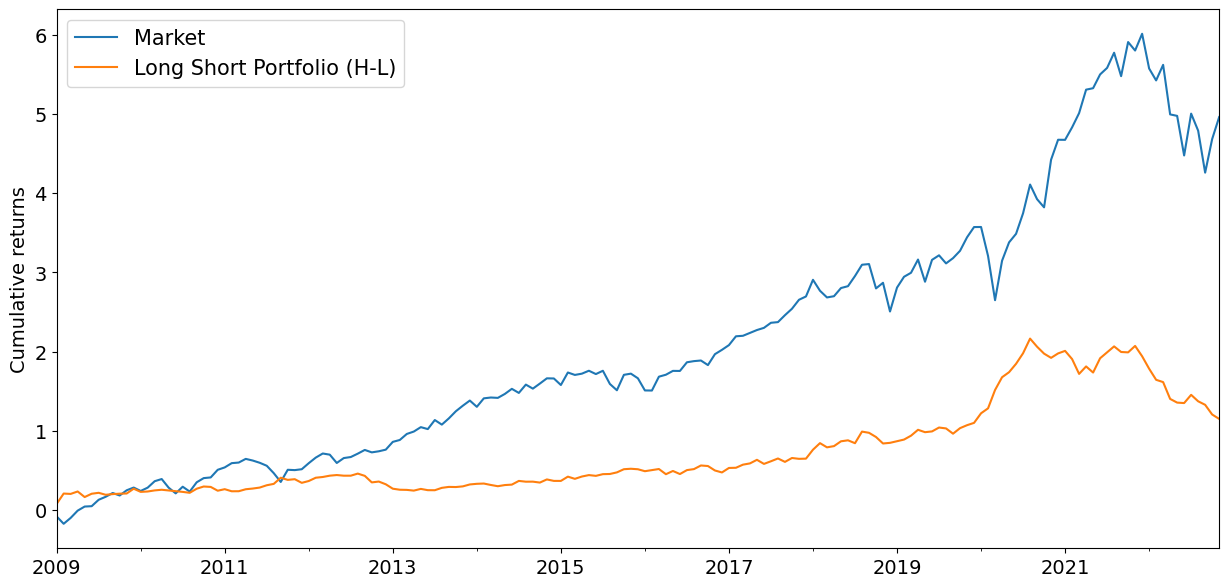

In [47]:
#plot the cumulative returns of the long-short and market portfolios
temp['LS'] = temp.quintile_4 - temp.quintile_0
((temp[['Mkt','LS']]+1).cumprod()-1).plot(figsize = (15,7))

plt.legend(['Market','Long Short Portfolio (H-L)'], fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Cumulative returns', fontsize = 14)
plt.show()

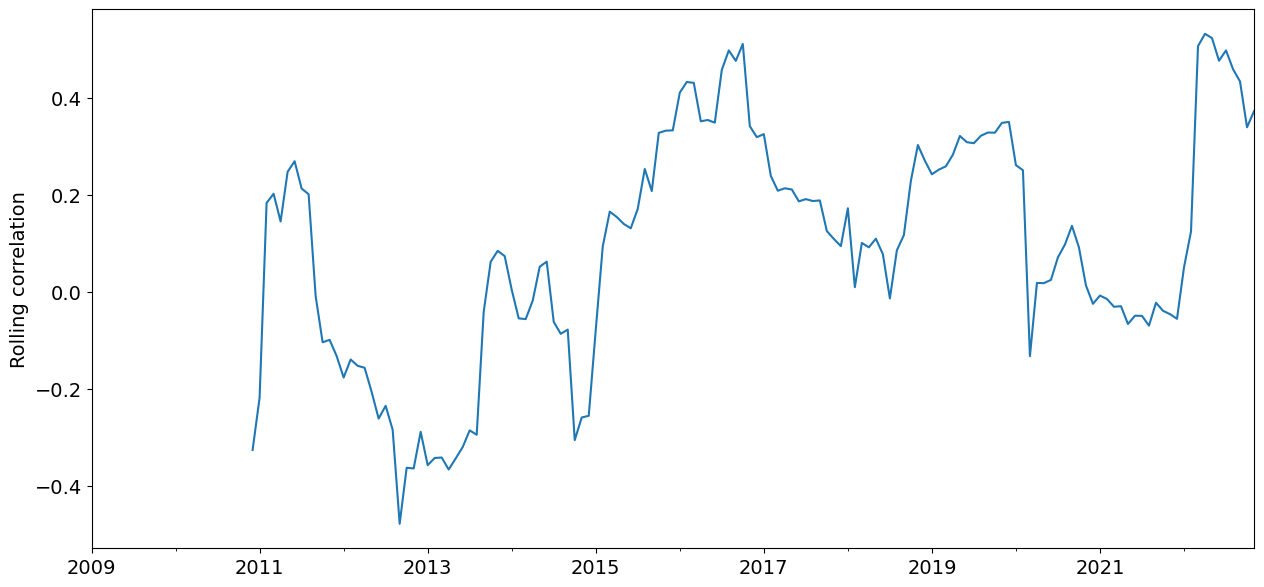

In [48]:
#plot the rolling 24 month correlation between the long-short portfolio and the market 
temp['Mkt'].rolling(window = 24).corr(temp['LS']).plot(figsize = (15,7))

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Rolling correlation', fontsize = 14)
plt.show()

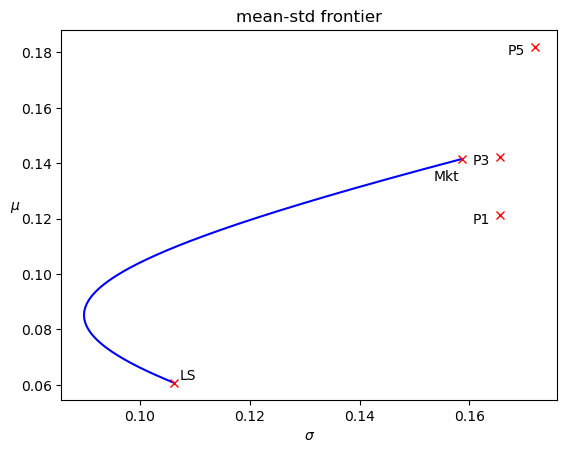

The minimum variance portfolio is 69.67% LS and 30.33% Mkt.
Its Sharpe ratio is 0.89


In [49]:
#compute the mean efficient frontier using the long-short and market portfolios
weight = np.linspace(0,1,1000)
portfolio_ret = weight*temp.LS.mean()*12 +(1-weight)*temp.Mkt.mean()*12
portfolio_std = np.sqrt(weight**2 * temp.LS.var()*12 + (1-weight)**2 * temp.Mkt.var()*12 +
                        2*weight*(1-weight)*temp.cov()['LS']['Mkt']*12)

plt.plot(portfolio_std, portfolio_ret, color = 'blue')
plt.annotate('LS', [temp.LS.std()*np.sqrt(12),temp.LS.mean()*12],
             [temp.LS.std()*np.sqrt(12)+0.001,temp.LS.mean()*12+0.001])
plt.plot(temp.LS.std()*np.sqrt(12),temp.LS.mean()*12, 'rx')
plt.annotate('Mkt', [temp.Mkt.std()*np.sqrt(12),temp.Mkt.mean()*12],
             [temp.Mkt.std()*np.sqrt(12)-0.005,temp.Mkt.mean()*12-0.008])
plt.plot(temp.Mkt.std()*np.sqrt(12),temp.Mkt.mean()*12, 'rx')

plt.annotate('P1', [temp.quintile_0.std()*np.sqrt(12),temp.quintile_0.mean()*12],
             [temp.quintile_0.std()*np.sqrt(12)-0.005,temp.quintile_0.mean()*12-0.003])
plt.plot(temp.quintile_0.std()*np.sqrt(12),temp.quintile_0.mean()*12, 'rx')
plt.annotate('P3', [temp.quintile_2.std()*np.sqrt(12),temp.quintile_2.mean()*12],
             [temp.quintile_2.std()*np.sqrt(12)-0.005,temp.quintile_2.mean()*12-0.003])
plt.plot(temp.quintile_2.std()*np.sqrt(12),temp.quintile_2.mean()*12, 'rx')
plt.annotate('P5', [temp.quintile_4.std()*np.sqrt(12),temp.quintile_4.mean()*12],
             [temp.quintile_4.std()*np.sqrt(12)-0.005,temp.quintile_4.mean()*12-0.003])
plt.plot(temp.quintile_4.std()*np.sqrt(12),temp.quintile_4.mean()*12, 'rx')

plt.title('mean-std frontier')
plt.xlabel('$\sigma$')
plt.ylabel('$\mu$').set_rotation(0)
plt.show()


rf = FF5.loc[temp.index,:].RF.mean()*12
SR = (portfolio_ret[portfolio_std.argmin()]-rf)/portfolio_std.min()
print(f'The minimum variance portfolio is {round(weight[np.argmin(portfolio_std)]*100,2)}% LS and '+
      f'{round((1-weight[np.argmin(portfolio_std)])*100,2)}% Mkt.')
print(f'Its Sharpe ratio is {round(SR,2)}')

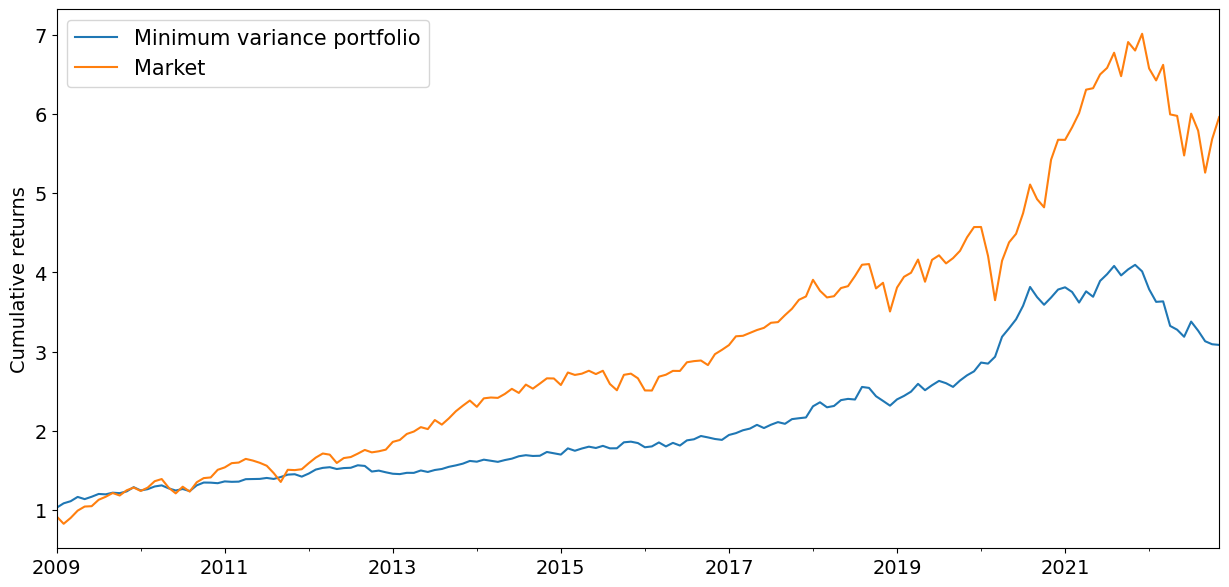

In [50]:
#plot the cumulative returns of the minimum variance portfolio
x = weight[np.argmin(portfolio_std)]
portfolio_ret = x*temp.LS +(1-x)*temp.Mkt

(1+portfolio_ret).cumprod().plot(figsize = (15,7))
(1+temp.Mkt).cumprod().plot(figsize = (15,7))
plt.legend(['Minimum variance portfolio','Market'], fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Cumulative returns', fontsize = 14)
plt.show()

In [51]:
#value weighted excess returns and alphas
table, pval_table, t_stat_table, Ratio_table = get_alphas(vw_ret, FF5)
print('Value weighted portfolios')
display(table.style.format("{:.3%}"))
print('p-values:')
display(pval_table.style.format("{:.3f}"))
print('t stats:')
display(t_stat_table.style.format("{:.3f}"))
print('Annualized ratios:')
display(Ratio_table.style.format("{:.4}"))

Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.970%,1.046%,1.146%,1.194%,1.476%,0.506%
CAPM alpha,-0.151%,-0.003%,-0.004%,0.069%,0.326%,0.477%
FFC alpha,-0.086%,0.046%,0.042%,0.085%,0.235%,0.321%
FF5 alpha,-0.097%,-0.031%,0.048%,0.050%,0.252%,0.350%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.000,0.000,0.000,0.000,0.000,0.104
CAPM alpha,0.419,0.986,0.971,0.396,0.123,0.208
FFC alpha,0.327,0.649,0.652,0.247,0.068,0.090
FF5 alpha,0.160,0.707,0.610,0.395,0.057,0.036


t stats:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,3.607,4.006,3.987,4.099,4.243,1.625
CAPM alpha,-0.809,-0.018,-0.036,0.849,1.542,1.259
FFC alpha,-0.981,0.456,0.451,1.158,1.823,1.694
FF5 alpha,-1.404,-0.376,0.511,0.851,1.903,2.098


Annualized ratios:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Annualized Sharpe Ratio,0.7024,0.8204,0.8295,0.8834,1.029,0.5713
Annualized Treynor Ratio,0.03413,0.03933,0.03929,0.04184,0.05062,2.027
Annualized Sortino Ratio,1.058,1.305,1.346,1.417,1.777,2.818


In [24]:
#characteristics of the portfolios
tableB = pd.DataFrame(np.ones([2,5]), index = ['Number of firms', 'Cyber risk index'],
                      columns = ['Q1 (low)', 'Q2', 'Q3', 'Q4', 'Q5 (high)'])
tableB.loc['Number of firms',:] = np.mean(nb_firms, axis = 0)
tableB.loc['Cyber risk index',:] = np.mean(risk_index_quintiles, axis = 0)

tableB.style.format("{:.3f}")

,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,592.857,592.339,592.143,592.143,592.571
Cyber risk index,0.482,0.496,0.507,0.521,0.565


## Before Florackis

In [25]:
#dates = pd.date_range(start = '01-01-2009', end = '12-01-2022', freq = 'MS', inclusive = 'left')
dates = pd.date_range(start = '01-01-2009', end = '10-01-2020', freq = 'MS', inclusive = 'left')
quarters = dates[::3]
nb_firms = []
mkt_values = []
book_to_markets = []
ROAs = []
risk_index_quintiles = []

#drop firms with less than 3 years (table 7 caption)
general_cybersec = general_cybersec.loc[:,(~general_cybersec.isnull()).sum()>3]

ew_ret = {}
vw_ret = {}
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #Cyber scores for the year
        Cybersec = general_cybersec.loc[month.year,:].dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],Cybersec.index].dropna()
        Cybersec = Cybersec.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:dates[i+1]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        Cybersec = Cybersec[Cybersec.index.isin(firms_with_ret)]

        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[Cybersec.index.values]
        fd[fd_col] = pd.to_datetime(fd[fd_col])

        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        Cybersec.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        Cybersec.dropna(inplace = True)
        mkt_caps_ = mkt_caps_.loc[mkt_caps_.index.isin(Cybersec.index)]

        #sort firms into quintiles
        quintiles = pd.qcut(Cybersec, q = 5, labels = False)

        quantile_weights = []
        for q in range(5):
            firms = quintiles[quintiles == q].index
            quantile_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))
            nb_firms.append(len(firms))
    
    ew_ret[month] = []
    vw_ret[month] = []
    for q in range(5):
        firms = quintiles[quintiles == q].index
        quantile_ret = returns.loc[month, firms]
        #equally weighted portfolios
        ew_ret[month].append(quantile_ret.mean())
        #value weighted portfolios
        vw_ret[month].append(quantile_ret.multiply(quantile_weights[q]).sum())
        
        #get current risk index of the portfolio
        cyber = general_cybersec.loc[month.year,firms]
        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[firms]
        fd[fd_col] = pd.to_datetime(fd[fd_col])
        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        cyber.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        risk_index_quintiles.append(cyber.multiply(quantile_weights[q]).sum())

idx = ['quintile_'+str(i) for i in range(5)]
ew_ret = pd.DataFrame(ew_ret, index = idx).T
vw_ret = pd.DataFrame(vw_ret, index = idx).T
risk_index_quintiles = np.reshape(risk_index_quintiles,(-1,5))
nb_firms = np.reshape(nb_firms,(-1,5))

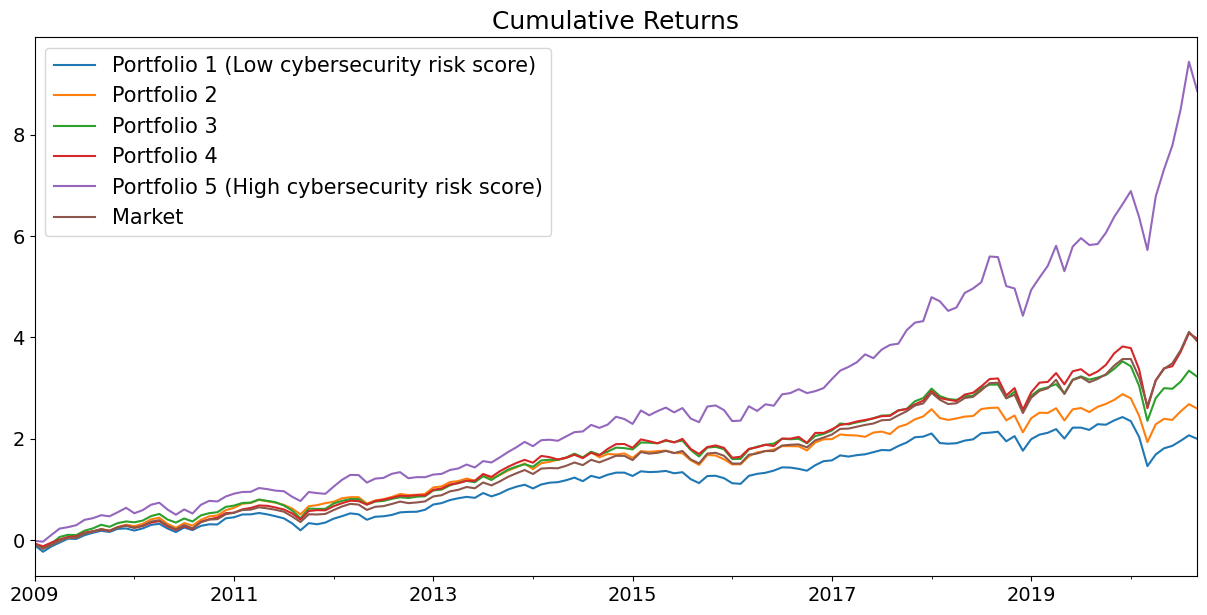

In [26]:
#plot the cumulative return of the quintile portfolios and the market portfolio
Mkt = FF5['Mkt-RF'].add(FF5['RF'])
Mkt.name = 'Mkt'
temp = pd.concat([vw_ret, Mkt[Mkt.index.isin(vw_ret.index)]], axis = 1)
#temp['LS'] = temp.quintile_4.sub(temp.quintile_0)
((temp+1).cumprod()-1).plot(figsize = (15,7))
plt.title('Cumulative Returns', fontsize = 18)
plt.legend(['Portfolio 1 (Low cybersecurity risk score)', 'Portfolio 2', 'Portfolio 3',
            'Portfolio 4', 'Portfolio 5 (High cybersecurity risk score)',
            'Market'], fontsize = 15)#,'Long Short Portfolio (H-L)'
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [27]:
#value weighted excess returns and alphas
table, pval_table, t_stat_table, Ratio_table = get_alphas(vw_ret, FF5)
print('Value weighted portfolios')
display(table.style.format("{:.2%}"))
print('p-values:')
display(pval_table.style.format("{:.3f}"))
print('t stats:')
display(t_stat_table.style.format("{:.3f}"))
print('Annualized ratios:')
display(Ratio_table.style.format("{:.4}"))

Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.85%,0.97%,1.09%,1.20%,1.70%,0.85%
CAPM alpha,-0.36%,-0.18%,-0.11%,0.03%,0.54%,0.90%
FFC alpha,-0.16%,-0.03%,-0.03%,0.02%,0.24%,0.40%
FF5 alpha,-0.14%,-0.08%,-0.02%,-0.00%,0.29%,0.42%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.002,0.000,0.000,0.000,0.000,0.005
CAPM alpha,0.018,0.155,0.352,0.773,0.019,0.012
FFC alpha,0.025,0.714,0.671,0.843,0.089,0.041
FF5 alpha,0.031,0.336,0.784,0.943,0.066,0.023


t stats:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,3.030,3.575,3.942,5.169,5.805,2.791
CAPM alpha,-2.375,-1.424,-0.930,0.289,2.353,2.515
FFC alpha,-2.242,-0.366,-0.425,0.198,1.703,2.048
FF5 alpha,-2.160,-0.962,-0.274,-0.071,1.838,2.278


Annualized ratios:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Annualized Sharpe Ratio,0.6333,0.7689,0.8315,0.9336,1.273,1.019
Annualized Treynor Ratio,0.02913,0.03492,0.03753,0.04228,0.06072,-1.414
Annualized Sortino Ratio,0.9158,1.187,1.314,1.481,2.417,4.178


In [28]:
#characteristics of the portfolios
tableB = pd.DataFrame(np.ones([2,5]), index = ['Number of firms', 'Cyber risk index'],
                      columns = ['Q1 (low)', 'Q2', 'Q3', 'Q4', 'Q5 (high)'])
tableB.loc['Number of firms',:] = np.mean(nb_firms, axis = 0)
tableB.loc['Cyber risk index',:] = np.mean(risk_index_quintiles, axis = 0)

tableB.style.format("{:.3f}")

,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,577.702,577.277,577.000,577.021,577.426
Cyber risk index,0.482,0.495,0.505,0.520,0.565


## After Florackis

In [29]:
#dates = pd.date_range(start = '01-01-2009', end = '12-01-2022', freq = 'MS', inclusive = 'left')
dates = pd.date_range(start = '11-01-2020', end = '12-01-2022', freq = 'MS', inclusive = 'left')
quarters = dates[::3]
nb_firms = []
mkt_values = []
book_to_markets = []
ROAs = []
risk_index_quintiles = []

#drop firms with less than 3 years (table 7 caption)
general_cybersec = general_cybersec.loc[:,(~general_cybersec.isnull()).sum()>3]

ew_ret = {}
vw_ret = {}
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #Cyber scores for the year
        Cybersec = general_cybersec.loc[month.year,:].dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],Cybersec.index].dropna()
        Cybersec = Cybersec.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:dates[i]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        Cybersec = Cybersec[Cybersec.index.isin(firms_with_ret)]

        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[Cybersec.index.values]
        fd[fd_col] = pd.to_datetime(fd[fd_col])

        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        Cybersec.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        Cybersec.dropna(inplace = True)
        mkt_caps_ = mkt_caps_.loc[mkt_caps_.index.isin(Cybersec.index)]

        #sort firms into quintiles
        quintiles = pd.qcut(Cybersec, q = 5, labels = False)

        quantile_weights = []
        for q in range(5):
            firms = quintiles[quintiles == q].index
            quantile_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))
            nb_firms.append(len(firms))
    
    ew_ret[month] = []
    vw_ret[month] = []
    for q in range(5):
        firms = quintiles[quintiles == q].index
        quantile_ret = returns.loc[month, firms]
        #equally weighted portfolios
        ew_ret[month].append(quantile_ret.mean())
        #value weighted portfolios
        vw_ret[month].append(quantile_ret.multiply(quantile_weights[q]).sum())
        
        #get current risk index of the portfolio
        cyber = general_cybersec.loc[month.year,firms]
        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[firms]
        fd[fd_col] = pd.to_datetime(fd[fd_col])
        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        cyber.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        risk_index_quintiles.append(cyber.multiply(quantile_weights[q]).sum())

idx = ['quintile_'+str(i) for i in range(5)]
ew_ret = pd.DataFrame(ew_ret, index = idx).T
vw_ret = pd.DataFrame(vw_ret, index = idx).T
risk_index_quintiles = np.reshape(risk_index_quintiles,(-1,5))
nb_firms = np.reshape(nb_firms,(-1,5))

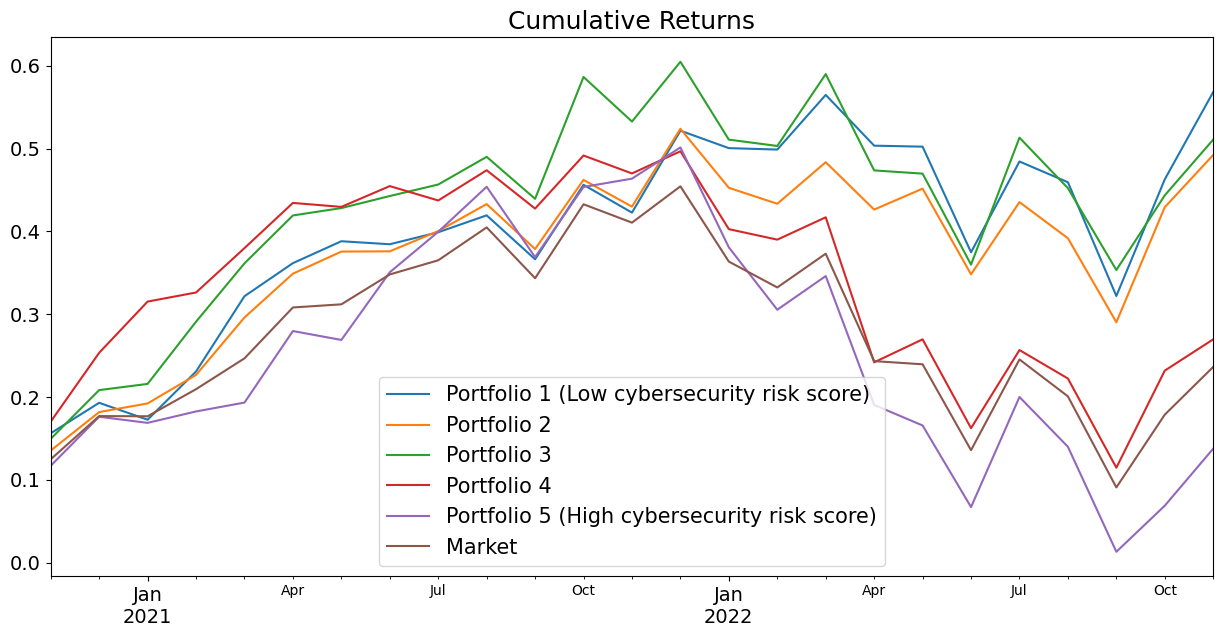

In [30]:
#plot the cumulative return of the quintile portfolios and the market portfolio
Mkt = FF5['Mkt-RF'].add(FF5['RF'])
Mkt.name = 'Mkt'
temp = pd.concat([vw_ret, Mkt[Mkt.index.isin(vw_ret.index)]], axis = 1)
#temp['LS'] = temp.quintile_4.sub(temp.quintile_0)
((temp+1).cumprod()-1).plot(figsize = (15,7))
plt.title('Cumulative Returns', fontsize = 18)
plt.legend(['Portfolio 1 (Low cybersecurity risk score)', 'Portfolio 2', 'Portfolio 3',
            'Portfolio 4', 'Portfolio 5 (High cybersecurity risk score)',
            'Market'], fontsize = 15)#,'Long Short Portfolio (H-L)'
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [31]:
#value weighted excess returns and alphas
table, pval_table, t_stat_table, Ratio_table = get_alphas(vw_ret, FF5)
print('Value weighted portfolios')
display(table.style.format("{:.2%}"))
print('p-values:')
display(pval_table.style.format("{:.3f}"))
print('t stats:')
display(t_stat_table.style.format("{:.3f}"))
print('Annualized ratios:')
display(Ratio_table.style.format("{:.4}"))

Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,1.93%,1.69%,1.78%,1.10%,0.68%,-1.24%
CAPM alpha,1.03%,0.87%,0.82%,0.10%,-0.39%,-1.43%
FFC alpha,0.46%,0.38%,0.76%,-0.25%,0.24%,-0.22%
FF5 alpha,0.14%,0.14%,0.80%,-0.19%,0.14%,0.00%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.052,0.101,0.150,0.475,0.635,0.044
CAPM alpha,0.001,0.000,0.000,0.761,0.065,0.003
FFC alpha,0.199,0.011,0.005,0.021,0.327,0.706
FF5 alpha,0.743,0.383,0.009,0.046,0.623,0.995


t stats:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,1.943,1.641,1.439,0.714,0.475,-2.011
CAPM alpha,3.328,5.316,5.379,0.304,-1.848,-2.962
FFC alpha,1.285,2.537,2.799,-2.310,0.980,-0.378
FF5 alpha,0.328,0.872,2.618,-1.997,0.491,0.006


Annualized ratios:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Annualized Sharpe Ratio,1.16,1.138,1.042,0.6061,0.3581,-1.124
Annualized Treynor Ratio,0.0719,0.0685,0.06145,0.03649,0.02115,0.1247
Annualized Sortino Ratio,2.311,2.213,2.016,0.9953,0.5311,0.7048


In [32]:
#characteristics of the portfolios
tableB = pd.DataFrame(np.ones([2,5]), index = ['Number of firms', 'Cyber risk index'],
                      columns = ['Q1 (low)', 'Q2', 'Q3', 'Q4', 'Q5 (high)'])
tableB.loc['Number of firms',:] = np.mean(nb_firms, axis = 0)
tableB.loc['Cyber risk index',:] = np.mean(risk_index_quintiles, axis = 0)

tableB.style.format("{:.3f}")

,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,671.889,671.222,671.222,671.222,671.556
Cyber risk index,0.485,0.501,0.514,0.529,0.569


### Long-run cyber risk score

In [33]:
dates = pd.date_range(start = '01-01-2009', end = '12-01-2022', freq = 'MS', inclusive = 'left')
quarters = dates[::3]
nb_firms = []
mkt_values = []
book_to_markets = []
ROAs = []
risk_index_quintiles = []

#drop firms with less than 3 years (table 7 caption)
long_term_cybersec = long_term_cybersec.loc[:,(~long_term_cybersec.isnull()).sum()>3]

ew_ret = {}
vw_ret = {}
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #Cyber scores for the year
        Cybersec = long_term_cybersec.loc[month.year,:].dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],Cybersec.index].dropna()
        Cybersec = Cybersec.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:dates[i+1]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        Cybersec = Cybersec[Cybersec.index.isin(firms_with_ret)]

        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[Cybersec.index.values]
        fd[fd_col] = pd.to_datetime(fd[fd_col])

        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        Cybersec.loc[idx_not_filled] = long_term_cybersec.loc[month.year-1,idx_not_filled]
        Cybersec.dropna(inplace = True)
        mkt_caps_ = mkt_caps_.loc[mkt_caps_.index.isin(Cybersec.index)]

        #sort firms into quintiles
        quintiles = pd.qcut(Cybersec, q = 5, labels = False)

        quantile_weights = []
        for q in range(5):
            firms = quintiles[quintiles == q].index
            quantile_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))
            nb_firms.append(len(firms))
    
    ew_ret[month] = []
    vw_ret[month] = []
    for q in range(5):
        firms = quintiles[quintiles == q].index
        quantile_ret = returns.loc[month, firms]
        #equally weighted portfolios
        ew_ret[month].append(quantile_ret.mean())
        #value weighted portfolios
        vw_ret[month].append(quantile_ret.multiply(quantile_weights[q]).sum())
        
        #get current risk index of the portfolio
        cyber = long_term_cybersec.loc[month.year,firms]
        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[firms]
        fd[fd_col] = pd.to_datetime(fd[fd_col])
        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        cyber.loc[idx_not_filled] = long_term_cybersec.loc[month.year-1,idx_not_filled]
        risk_index_quintiles.append(cyber.multiply(quantile_weights[q]).sum())

idx = ['quintile_'+str(i) for i in range(5)]
ew_ret = pd.DataFrame(ew_ret, index = idx).T
vw_ret = pd.DataFrame(vw_ret, index = idx).T
risk_index_quintiles = np.reshape(risk_index_quintiles,(-1,5))
nb_firms = np.reshape(nb_firms,(-1,5))

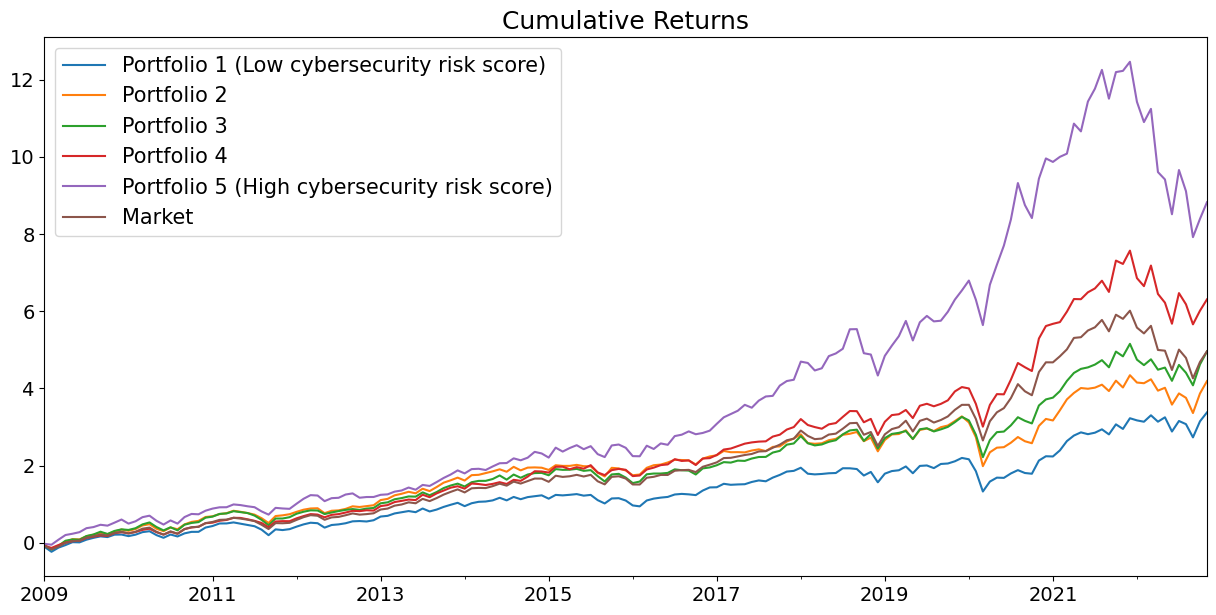

In [34]:
#plot the cumulative return of the quintile portfolios and the market portfolio
Mkt = FF5['Mkt-RF'].add(FF5['RF'])
Mkt.name = 'Mkt'
temp = pd.concat([vw_ret, Mkt[Mkt.index.isin(vw_ret.index)]], axis = 1)
#temp['LS'] = temp.quintile_4.sub(temp.quintile_0)
((temp+1).cumprod()-1).plot(figsize = (15,7))
plt.title('Cumulative Returns', fontsize = 18)
plt.legend(['Portfolio 1 (Low cybersecurity risk score)', 'Portfolio 2', 'Portfolio 3',
            'Portfolio 4', 'Portfolio 5 (High cybersecurity risk score)',
            'Market'], fontsize = 15)#,'Long Short Portfolio (H-L)'
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [35]:
#value weighted excess returns and alphas
table, pval_table, t_stat_table, Ratio_table = get_alphas(vw_ret, FF5)
print('Value weighted portfolios')
display(table.style.format("{:.2%}"))
print('p-values:')
display(pval_table.style.format("{:.3f}"))
print('t stats:')
display(t_stat_table.style.format("{:.3f}"))
print('Annualized ratios:')
display(Ratio_table.style.format("{:.4}"))

Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.96%,1.06%,1.14%,1.26%,1.46%,0.50%
CAPM alpha,-0.16%,-0.04%,0.02%,0.18%,0.30%,0.46%
FFC alpha,-0.09%,0.04%,0.08%,0.15%,0.21%,0.30%
FF5 alpha,-0.07%,-0.04%,-0.00%,0.12%,0.25%,0.32%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.000,0.000,0.000,0.000,0.000,0.126
CAPM alpha,0.423,0.826,0.902,0.000,0.168,0.245
FFC alpha,0.317,0.737,0.457,0.010,0.104,0.102
FF5 alpha,0.361,0.684,0.958,0.032,0.072,0.067


t stats:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,3.605,3.628,4.147,4.680,4.069,1.529
CAPM alpha,-0.801,-0.220,0.124,3.698,1.379,1.162
FFC alpha,-1.000,0.336,0.744,2.583,1.627,1.637
FF5 alpha,-0.914,-0.407,-0.053,2.147,1.797,1.833


Annualized ratios:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Annualized Sharpe Ratio,0.6944,0.7897,0.8429,0.9721,1.01,0.542
Annualized Treynor Ratio,0.0338,0.03801,0.04,0.04621,0.04977,1.732
Annualized Sortino Ratio,1.046,1.227,1.374,1.654,1.728,2.618


In [36]:
#characteristics of the portfolios
tableB = pd.DataFrame(np.ones([2,5]), index = ['Number of firms', 'Cyber risk index'],
                      columns = ['Q1 (low)', 'Q2', 'Q3', 'Q4', 'Q5 (high)'])
tableB.loc['Number of firms',:] = np.mean(nb_firms, axis = 0)
tableB.loc['Cyber risk index',:] = np.mean(risk_index_quintiles, axis = 0)

tableB.style.format("{:.3f}")

,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,592.857,592.179,592.250,592.196,592.571
Cyber risk index,0.484,0.495,0.505,0.518,0.565


## Exclude cyber security firms

In [37]:
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)
stocknames.FF_Industry_code = stocknames.FF_Industry_code.astype(float)

#read in the holdings of the HACK ETF
HACK_holdings = pd.read_csv('../data/HACK_fund_holdings.csv')
#identify firms that are in my sample
cyber_firms = HACK_holdings.loc[HACK_holdings.StockTicker.isin(stocknames.ticker),'StockTicker'].values

In [38]:
#read in the necessary files (firm characteristics)
read_path = '../data/returns/'
mkt_caps = pd.read_csv(read_path+'monthly_mkt_caps.csv.gz', index_col = 'date')
returns = pd.read_csv(read_path+'monthly_returns.csv.gz', index_col = 'date')
#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)
stocknames.FF_Industry_code = stocknames.FF_Industry_code.astype(float)
#read in the general cybersecurity measure
cyber_measures_path = '../data/cyber_risk_measures/doc2vec/'
general_cybersec = pd.read_csv(cyber_measures_path+'general_cybersec_scores_no1A.csv.gz', index_col = 0)


returns.index = pd.to_datetime(returns.index)
mkt_caps.index = pd.to_datetime(mkt_caps.index)

#Factor returns
FF5 = pd.read_csv('../data/FF_factors/FF5.csv',skiprows = 3, index_col = 0)[:714].astype(float)
FF5 = FF5/100 # in percent?????
FF5.index.rename('date', inplace = True)
FF5.index = pd.to_datetime(FF5.index, format = '%Y%m')
momentum = pd.read_csv('../data/FF_factors/Momentum.csv',skiprows = 13, index_col = 0)[:1153].astype(float)
momentum = momentum/100 # in percent?????
momentum.index.rename('date', inplace = True)
momentum.index = pd.to_datetime(momentum.index, format = '%Y%m')
momentum.columns = ['UMD']
FF5 = FF5.merge(momentum,left_index = True,right_index = True)

In [39]:
#Average cyber security score of the cyber security firms
avg_cyber_score = general_cybersec.loc[:,cyber_firms].mean().mean()
print(f'Average cyber score of the cyber security firms is '+ 
      f'{round(avg_cyber_score,4)}')

percentile = percentileofscore(general_cybersec.stack(), avg_cyber_score)
print(f'This corresponds to the {round(percentile, 4)}th percentile of cyber security risk')

Average cyber score of the cyber security firms is 0.5872
This corresponds to the 97.4349th percentile of cyber security risk


In [40]:
dates = pd.date_range(start = '01-01-2009', end = '12-01-2022', freq = 'MS', inclusive = 'left')
quarters = dates[::3]
nb_firms = []
mkt_values = []
book_to_markets = []
ROAs = []
risk_index_quintiles = []

#drop firms with less than 3 years (table 7 caption)
general_cybersec = general_cybersec.loc[:,(~general_cybersec.isnull()).sum()>3]

#drop cyber security firms
general_cybersec = general_cybersec.loc[:,~general_cybersec.columns.isin(cyber_firms)]

ew_ret = {}
vw_ret = {}
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #Cyber scores for the year
        Cybersec = general_cybersec.loc[month.year,:].dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],Cybersec.index].dropna()
        Cybersec = Cybersec.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:dates[i+1]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        Cybersec = Cybersec[Cybersec.index.isin(firms_with_ret)]

        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[Cybersec.index.values]
        fd[fd_col] = pd.to_datetime(fd[fd_col])

        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        Cybersec.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        Cybersec.dropna(inplace = True)
        mkt_caps_ = mkt_caps_.loc[mkt_caps_.index.isin(Cybersec.index)]

        #sort firms into quintiles
        quintiles = pd.qcut(Cybersec, q = 5, labels = False)

        quantile_weights = []
        for q in range(5):
            firms = quintiles[quintiles == q].index
            quantile_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))
            nb_firms.append(len(firms))
    
    ew_ret[month] = []
    vw_ret[month] = []
    for q in range(5):
        firms = quintiles[quintiles == q].index
        quantile_ret = returns.loc[month, firms]
        #equally weighted portfolios
        ew_ret[month].append(quantile_ret.mean())
        #value weighted portfolios
        vw_ret[month].append(quantile_ret.multiply(quantile_weights[q]).sum())
        
        #get current risk index of the portfolio
        cyber = general_cybersec.loc[month.year,firms]
        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[firms]
        fd[fd_col] = pd.to_datetime(fd[fd_col])
        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        cyber.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        risk_index_quintiles.append(cyber.multiply(quantile_weights[q]).sum())

idx = ['quintile_'+str(i) for i in range(5)]
ew_ret = pd.DataFrame(ew_ret, index = idx).T
vw_ret = pd.DataFrame(vw_ret, index = idx).T
risk_index_quintiles = np.reshape(risk_index_quintiles,(-1,5))
nb_firms = np.reshape(nb_firms,(-1,5))

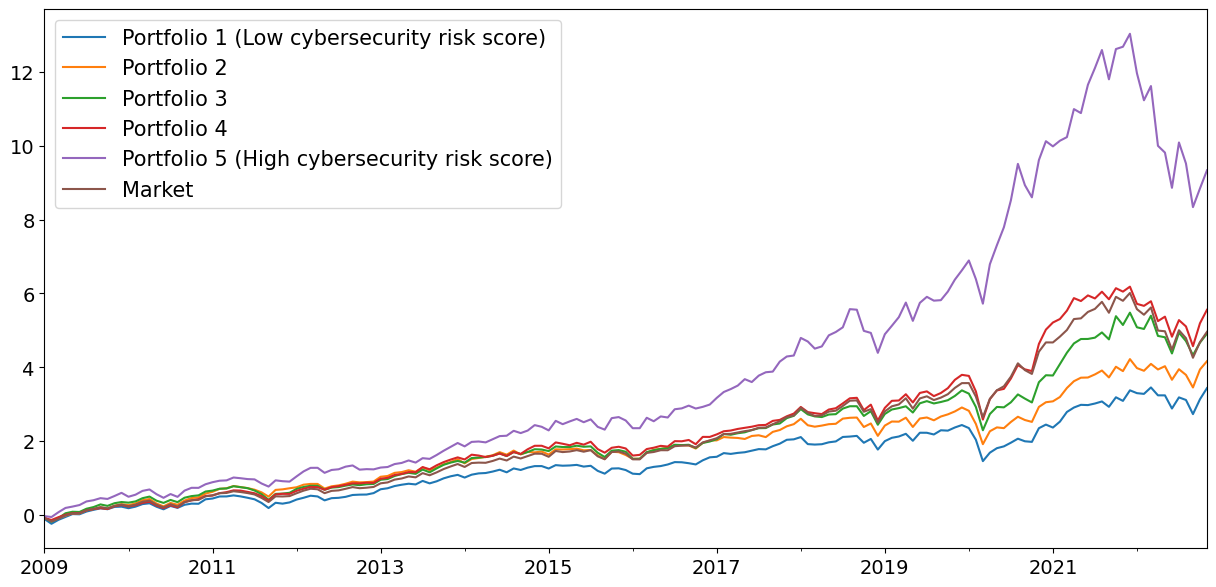

In [41]:
#plot the cumulative return of the quintile portfolios and the market portfolio
Mkt = FF5['Mkt-RF'].add(FF5['RF'])
Mkt.name = 'Mkt'
temp = pd.concat([vw_ret, Mkt[Mkt.index.isin(vw_ret.index)]], axis = 1)
#temp['LS'] = temp.quintile_4.sub(temp.quintile_0)
((temp+1).cumprod()-1).plot(figsize = (15,7))
#plt.title('Cumulative Returns', fontsize = 18)
plt.legend(['Portfolio 1 (Low cybersecurity risk score)', 'Portfolio 2', 'Portfolio 3',
            'Portfolio 4', 'Portfolio 5 (High cybersecurity risk score)',
            'Market'], fontsize = 15)#,'Long Short Portfolio (H-L)'
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [42]:
#value weighted excess returns and alphas
table, pval_table, t_stat_table, Ratio_table = get_alphas(vw_ret, FF5)
print('Value weighted portfolios')
display(table.style.format("{:.2%}"))
print('p-values:')
display(pval_table.style.format("{:.3f}"))
print('t stats:')
display(t_stat_table.style.format("{:.3f}"))
print('Annualized ratios:')
display(Ratio_table.style.format("{:.4}"))

Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.97%,1.05%,1.14%,1.20%,1.49%,0.52%
CAPM alpha,-0.15%,-0.02%,0.01%,0.08%,0.34%,0.49%
FFC alpha,-0.08%,0.03%,0.06%,0.09%,0.25%,0.33%
FF5 alpha,-0.09%,-0.04%,0.05%,0.06%,0.27%,0.36%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.000,0.000,0.000,0.000,0.000,0.102
CAPM alpha,0.428,0.925,0.937,0.338,0.110,0.201
FFC alpha,0.345,0.760,0.494,0.193,0.053,0.083
FF5 alpha,0.176,0.685,0.554,0.336,0.046,0.032


t stats:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,3.603,4.021,3.930,4.179,4.239,1.636
CAPM alpha,-0.792,-0.095,0.079,0.958,1.600,1.278
FFC alpha,-0.945,0.305,0.684,1.303,1.934,1.732
FF5 alpha,-1.353,-0.405,0.592,0.962,1.998,2.147


Annualized ratios:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Annualized Sharpe Ratio,0.7029,0.8111,0.8385,0.8891,1.041,0.5828
Annualized Treynor Ratio,0.03418,0.03886,0.03974,0.04212,0.05127,2.387
Annualized Sortino Ratio,1.058,1.285,1.36,1.431,1.8,2.844


In [43]:
#characteristics of the portfolios
tableB = pd.DataFrame(np.ones([2,5]), index = ['Number of firms', 'Cyber risk index'],
                      columns = ['Q1 (low)', 'Q2', 'Q3', 'Q4', 'Q5 (high)'])
tableB.loc['Number of firms',:] = np.mean(nb_firms, axis = 0)
tableB.loc['Cyber risk index',:] = np.mean(risk_index_quintiles, axis = 0)

tableB.style.format("{:.3f}")

,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,588.946,588.429,588.411,588.393,588.804
Cyber risk index,0.482,0.496,0.507,0.521,0.564
